# Расчетная работа по курсу: Теория вероятности и статистика<br/>Раздел 1

## Импортируем все необходимые библиотеки

Здесь:
- Numpy (`numpy` или `np`) - общий модуль для работы с тензорами и статистических вычислений

- SciPy
    - `stats` - для получения функции плотности вероятности из модуля `norm`
    - `optimize` - для получения функции минимизации
    - `integrate` - для подсчета интеграла

- MatPlotLib (`matplotlib.pyplot` или `plt`) - для графиков

- Regex (`re`) - встроенный модуль для работы с регулярными выражениями

In [1]:
import numpy as np

from scipy import stats
from scipy import optimize
import scipy.integrate as integrate

import matplotlib.pyplot as plt

import re

## Вводим константы по варианту и `SEED` для повторяемости результатов
$n=500$
<br/>$a_X=3.9$
<br/>$\sigma_X^2=4.3$
<br/>$\gamma=0.9$
<br/>$\alpha=0.025$<br/><br/>
Где:
<br/>$n$ - объем выборки
<br/>$a_X$ - математическое ожидание (mean)
<br/>$\sigma_X^2$ - дисперсия
<br/>$\gamma$ - доверительная вероятность
<br/>$\alpha$ - уровень значимости

In [2]:
n = 500             # Размер выборки
MX = 3.9            # Мат. ожидание 
DX = 4.3            # Дисперсия
SIGMA = np.sqrt(DX) # Среднее квадратичное отклонение, квадратный корень дисперсии

SEED = 0            # Для повторяемости результатов

## 1.0 Функция нормального (Гауссовского) распределения случайной величины
$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-a)^{2}}{2\sigma^{2}}}$$

Для генерации выборки воспльзуемся `scipy`

In [3]:
x: np.ndarray = stats.norm.rvs(loc=MX, scale=SIGMA, size=n, random_state=SEED)
print(f"Первые 6 значений вектора:\n{re.sub(" +", ", ", str(x[:6])[1:-1])}...")
print(f"Размерность выборки: {str(x.shape)[1:-2]}")

Первые 6 значений вектора:
7.5580168, 4.72978365, 5.92955428, 8.54681504, 7.77265067, 1.87347346...
Размерность выборки: 500


## 1.1 Гистограмма полученного вектора выборки и теоретической
Получанный вектор:

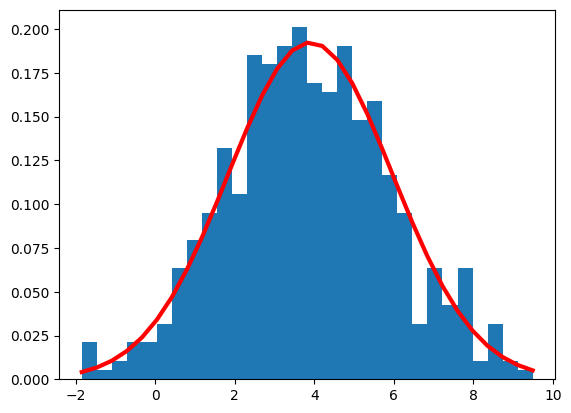

In [4]:
_, theoretic_x, _ = plt.hist(x, 30, density=True)

theoretic_normal_distribution = 1 / \
    (SIGMA * np.sqrt(2 * np.pi)) * \
    np.exp(- (theoretic_x - MX)**2 / (2 * SIGMA**2))

plt.plot(theoretic_x, theoretic_normal_distribution, linewidth=3, color='r')
plt.show()

## 1.2 Выборчная средняя и дисперсия

Формула для выборочной средней:

$$\bar{X} = \frac{1}{n}\sum_{i=0}^{n-1}x_{i}$$

Формула для выборочной дисперсии:

$$S^2 = \frac{1}{n}\sum_{i=0}^{n-1}(x_{i}-\bar{x})^2$$

In [5]:
sample_average = x.sum() / n

sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - sample_average) ** 2

sample_variance = sum_tmp / n

print(f"Выборочная средняя: {sample_average}\nВыборочная дисперсия: {sample_variance}")

Выборочная средняя: 3.8474239155736476
Выборочная дисперсия: 4.284162894269144


## 1.3 Получить оценки мат. ожидания и дисперсии методом максимального правдоподобия

In [6]:
def likelihood(params, x):
    return stats.norm.logpdf(x, loc=params[0], scale=params[1]).sum()

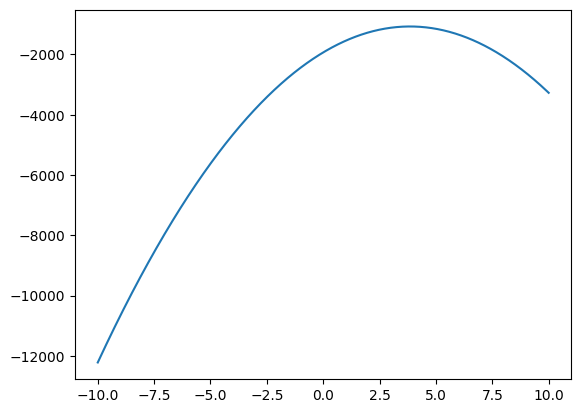

In [7]:
plt.plot(np.linspace(-10, 10, 1000), [likelihood([val, SIGMA], x) for val in np.linspace(-10, 10, 1000)])
plt.show()

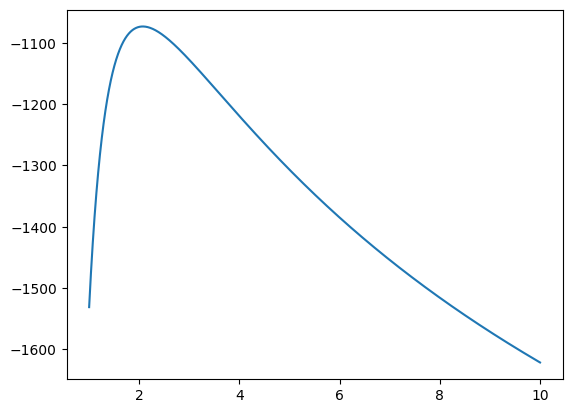

In [8]:
plt.plot(np.linspace(1, 10, 1000), [likelihood([MX, val], x) for val in np.linspace(1, 10, 1000)])
plt.show()

In [9]:
def neglikelihood_MX(MX):
    return -1 * likelihood([MX, SIGMA], x)

def neglikelihood_SIGMA(SIGMA):
    return -1 * likelihood([MX, SIGMA], x)

In [10]:
estimator_MX = optimize.minimize(neglikelihood_MX, 10).x
estimator_SIGMA = optimize.minimize(neglikelihood_SIGMA, 10).x
print(f"Оценка мат. ожидания: {str(estimator_MX)[1:-1]}\nОценка дисперсии: {str(estimator_SIGMA ** 2)[1:-1]}")

Оценка мат. ожидания: 3.84742389
Оценка дисперсии: 4.28692699


### Несмещнная оценка дисперсии
$$S'^{2}=\frac{1}{n-1}\sum^{n}_{i=1}(X_i-\bar{X})^2=\frac{n}{n-1}S^2$$

Тогда несмещенную оценку посчитаем используя выборочную дисперсию $S^2$

In [11]:
unbiased_variance = (n * sample_variance) / (n - 1)
print(f"Несмещенная оценка дисперсии: {unbiased_variance}")

Несмещенная оценка дисперсии: 4.292748391051247


## 1.4 Построить доверительные интервалы для MX и DX, соответсвующие $\gamma$

### 1.4.1 Найдем интервальные оценки при известных величинах

#### Формулы:

Формула для нахождения интервальной оценки MX, при известном DX: 
$$\Delta_{\gamma}(\theta)=(\bar{X}-c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}},\bar{X}+c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}})$$

где $\bar{X}$ - выборочное среднее<br/>*n* - размер выборки<br/>$c_{(1+\gamma)/2}$ - такое значение функции Лапласа $Ф(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-u^2/2}du$, при котором $Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$<br/>$c_{(1+\gamma)/2}$ находят по таблице Б.2

Формула для нахождения интервальной оценки DX, при известном MX:
$$\Delta_{\gamma}(\theta^2)=\Big(\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1+\gamma)/2;n}};\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1-\gamma)/2;n}}\Big)$$

где $\chi^2_{(1+\gamma)/2;n}$ это $(1+\gamma)/2$ квантили распределения $\chi^2(n)$ с *n* степенями свободы<br/>
Искать в таблице Г.2

#### Найдем интервальную оценку MX
Получим $c_{(1+\gamma)/2}$ используя таблицу, при $\gamma=0.9$.<br/><br/>
Решим уравнение:
$$Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$$
$$Ф(c_{(1+\gamma)/2})=0.95$$
Тогда $c_{(1+\gamma)/2}=1.645$

In [12]:
interval_MX_with_known_DX = sample_average - 1.645 * (SIGMA / np.sqrt(n)), sample_average + 1.645 * (SIGMA / np.sqrt(n))

print(f"Интервальная оценка MX, с известной DX: {interval_MX_with_known_DX}")

Интервальная оценка MX, с известной DX: (3.6948728913227433, 3.999974939824552)


#### Найдем интервальную оценку DX
Так как $n\ge30$ ($n=500$), то воспользуемся формулой: $$\chi^2_{\gamma,n}\approx\frac{(c_p+\sqrt{2n-1})^2}{2}$$
где $c_p$ квантиль нормального распределения из таблицы Б.2 <br/>
Возьмем значения из таблицы: 
$$c_p=1.645 \quad \text{(при} \> p=(1+\gamma)/2=0.95\text{)}$$
$$c_p=-1.645 \quad \text{(при} \> p=(1-\gamma)/2=0.05\text{)}$$
<br/>Тогда:
$$\chi^2_{(1+\gamma)/2;n}\approx552.84646$$
$$\chi^2_{(1-\gamma)/2;n}\approx448.85956$$

In [13]:
sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - MX) ** 2

interval_DX_with_known_MX = sum_tmp / 552.84646, sum_tmp / 448.85956

print(f"Интервальная оценка DX, с известным MX: {interval_DX_with_known_MX}")

Интервальная оценка DX, с известным MX: (3.877140805896408, 4.77535461083056)


### 1.4.2 Найдем интервальные оценки при неизвестных величинах

#### Формулы:

Формула для нахождения интервальной оценки MX, при неизвестном DX: 
$$\displaystyle
    \Delta_{\gamma}(\theta)=\Big( \bar{X} - t_{(1+\gamma)/2;n-1} \frac S{\sqrt{n-1}}; 
                            \quad \bar{X} + t_{(1+\gamma)/2;n-1} \frac S{\sqrt{n-1}} \Big)
$$

где $\bar{X}$ - выборочное среднее
<br/>*n* - размер выборки
<br/>$S^2$ - выборочная дисперсия $S = \sqrt{S^2}$
<br/>$t_{(1+\gamma)/2;n-1}$ - квантиль распределения Стьюдента, 
находят в таблице В.1, **НО** так как $n \ge 30$, то $t_{(1+\gamma)/2;n-1} \approx c_{(1+\gamma)/2}$, которую ищем по таблице Б.2

Тогда формула принимает вид:
$$\displaystyle
    \Delta_{\gamma}(\theta)=\Big( \bar{X} - c_{(1+\gamma)/2} \frac S{\sqrt{n-1}}; 
                            \quad \bar{X} + c_{(1+\gamma)/2} \frac S{\sqrt{n-1}} \Big)
$$

Формула для нахождения интервальной оценки DX, при неизвестном MX:
$$\displaystyle
    \Delta_{\gamma}(\theta^2) = \Big( \frac{nS^2}{\chi^2_{(1+\gamma)/2;n-1}}; 
                                \quad \frac{nS^2}{\chi^2_{(1-\gamma)/2;n-1}} \Big)
$$

где *n* - размер выборки
<br/>$S^2$ - выборочная дисперсия
<br/>$\chi^2_{(1+\gamma)/2;n-1}$ это $(1+\gamma)/2$ квантили распределения $\chi^2(n)$ с *n* степенями свободы<br/>
Искать в таблице Г.2

**НО** так как $n \ge 30$, мы можем воспользоваться другой формулой
$$\displaystyle
    \Delta_{\gamma}(\theta^2) = \Big( \frac{nS^2}{n-1+c_{(1+\gamma)/2}\sqrt{2(n-1)}}; 
                                \quad \frac{nS^2}{n-1-c_{(1+\gamma)/2}\sqrt{2(n-1)}} \Big)
$$
где $c_{(1+\gamma)/2}$ ищем в таблице Б.2

#### Найдем интеравльную оценку MX
Уже найденный ранее квантиль: $c_{(1+\gamma)/2}=1.645$

In [14]:
interval_MX_with_unknown_DX = (
    sample_average - 1.645 * (np.sqrt(sample_variance) / np.sqrt(n - 1)),
    sample_average + 1.645 * (np.sqrt(sample_variance) / np.sqrt(n - 1))
)
print(f"Интервальная оценка MX, с неизвестной DX: {interval_MX_with_unknown_DX}")

Интервальная оценка MX, с неизвестной DX: (3.695001578202156, 3.9998462529451393)


#### Найдем интервальную оценку DX
Уже найденный ранее квантиль: $c_{(1+\gamma)/2}=1.645$

In [15]:
interval_DX_with_unknown_MX = (
    (n * sample_variance) / (n - 1 + 1.645 * np.sqrt(2 * (n - 1))),
    (n * sample_variance) / (n - 1 - 1.645 * np.sqrt(2 * (n - 1)))
)
print(f"Интервальная оценка DX, с неизвестным MX: {interval_DX_with_unknown_MX}")

Интервальная оценка DX, с неизвестным MX: (3.8878550011789317, 4.791779285414053)


## 1.5 Проверка статестической гипотизы

### 1.5.1. Группировка по интервальным статистическим рядам и вычисление значение статистики

#### Построим вариационный ряд (упорядоченную выборку), то есть $x_1\le x_2\le ...\le x_n$

In [16]:
variation_series = x.copy()
variation_series.sort()
print(f"Вариационный ряд: {re.sub(" +", ", ", str(variation_series[:6])[1:-1])}...")

Вариационный ряд: -1.84937071, -1.78111549, -1.61417692, -1.60680896, -1.39399236, -0.84578352...


#### Разбиваем на непересекающиеся интервалы
Найдем мин. и макс. значение в ряде

In [17]:
print(f"Минимальное: {min(variation_series)}")
print(f"Максимальное: {max(variation_series)}")

Минимальное: -1.8493707090302478
Максимальное: 9.491009194141625


Кол-во интервалов, $N = [1+3.32 \lg n] + 1 = 10$

In [18]:
N = 10

Считаем длины интервалов: $$h=\frac{x_{max}-x_{min}}{N}$$

In [19]:
h = (max(variation_series) - min(variation_series)) / N
print(f"Длина интервала: {h}")

Длина интервала: 1.1340379903171873


Получаем такие интервалы:

In [20]:
J = [[min(variation_series) + k * h, min(variation_series) + (k + 1) * h] for k in range(N)]

for (i, interval) in enumerate(J):
    print(f"Интервал {i + 1}: {str(interval)[:-1]})")

Интервал 1: [-1.8493707090302478, -0.7153327187130605)
Интервал 2: [-0.7153327187130605, 0.41870527160412685)
Интервал 3: [0.41870527160412685, 1.552743261921314)
Интервал 4: [1.552743261921314, 2.6867812522385015)
Интервал 5: [2.6867812522385015, 3.820819242555689)
Интервал 6: [3.820819242555689, 4.954857232872875)
Интервал 7: [4.954857232872875, 6.088895223190063)
Интервал 8: [6.088895223190063, 7.22293321350725)
Интервал 9: [7.22293321350725, 8.356971203824438)
Интервал 10: [8.356971203824438, 9.491009194141625)


Разбиваем на интервалы

In [21]:
stat_series = [[] for _ in range(len(J))]

for xi in variation_series:
    for i in range(len(J)):
        if (J[i][0] <= xi < J[i][1]):
            stat_series[i].append(xi)
stat_series[-1].append(max(variation_series))

#### Теперь подсчитаем частоты

In [22]:
frequencies = []

for interval in stat_series:
    frequencies.append(len(interval))

relative_frequencies = [frequency / n for frequency in frequencies]

print(f"Частоты: {frequencies}")
print(f"Сумма частот: {sum(frequencies)}", end="\n\n")

print(f"Относительные частоты: {relative_frequencies}")
print(f"Сумма относительных частот: {sum(relative_frequencies)}")

Частоты: [7, 14, 45, 80, 108, 99, 80, 36, 22, 9]
Сумма частот: 500

Относительные частоты: [0.014, 0.028, 0.09, 0.16, 0.216, 0.198, 0.16, 0.072, 0.044, 0.018]
Сумма относительных частот: 1.0


### 1.5.2. Считаем критерий Пирсона, с известными MX и DX

Считаем по формуле: $$\chi^2_n=\sum^N_{k=1}\frac{(\nu_k-n p_k)^2}{n p_k}$$
Где $p_k$ считается по формуле: $$p_k = F(u_k)-F(u_{k-1})$$
Где $F(x)$ это: 

$$\displaystyle
    F(x) = \frac 12 \Big[ 1 + \text{erf}\Big(\frac {x - \mu}{\sigma \sqrt 2}\Big) \Big]
$$

где $\text{erf}$ - это:
$$\displaystyle
    \text{erf}(x) = \frac 2{\sqrt \pi} \int^x_0 e^{-t^2} dt
$$

Напишем функцию $F(x)$

In [23]:
def erf(x):
    return (2 / np.sqrt(np.pi)) * integrate.quad(lambda t: np.exp(- t**2), 0, x)[0]

def F(x, MX, SIGMA):
    return 0.5 * (1 + erf((x - MX) / (SIGMA * np.sqrt(2))))

Тогда $p_k$ это:

In [24]:
p = [F(val[-1], MX, SIGMA) - F(val[0], MX, SIGMA) for val in J]

for (k, pk) in enumerate(p):
    print(f"p{k + 1}{"" if k == 9 else " "} = {pk}")

p1  = 0.010236186814304549
p2  = 0.03357587882649371
p3  = 0.08223555956842171
p4  = 0.1504234500121049
p5  = 0.20551868995652528
p6  = 0.2097474539620901
p7  = 0.1599019000596832
p8  = 0.09105341070811945
p9  = 0.03872325168344848
p10 = 0.012297111136658878


In [25]:
chi = 0
for k in range(N):
    chi += (frequencies[k] - n * p[k])**2 / n * p[k]
print(f"Критерий Пирсона: {chi}")

Критерий Пирсона: 0.05300028107575772


### 1.5.3. Проверяем гипотезу, с известными MX и DX

По заданной $\alpha=0.025$ найдем порог для $\chi^2_{1-\alpha;N-1}$ по таблице Г.1 
$$1-\alpha=1-0.025=p=0.975$$
$$N-1=9$$
Где $N$ - это кол-во интервалов ($N=10$)

Тогда по таблице $\chi^2_{1-\alpha;N-1}=19.023$<br/>
Так как: $$\chi^2 < \chi^2_{1-\alpha;N-1} \Leftrightarrow 0.053 < 19.023 \Rightarrow \text{Гипотеза принимается}$$

### 1.5.4. Считаем критерий Пирсона, с неизвестными MX и DX

Вместо неизвестных MX и DX следует брать их точечные оценки, которые были получены при использовании метода максимального правдоподобия.

In [26]:
p = [F(val[-1], estimator_MX, estimator_SIGMA) - F(val[0], estimator_MX, estimator_SIGMA) for val in J]

for (k, pk) in enumerate(p):
    print(f"p{k + 1}{"" if k == 9 else " "} = {pk}")

p1  = 0.010805565860328048
p2  = 0.03508909479973754
p3  = 0.08500911473354172
p4  = 0.15367666391031448
p5  = 0.20732667424178491
p6  = 0.2087545993146414
p7  = 0.15687408417203996
p8  = 0.08797781004270733
p9  = 0.036816913806524854
p10 = 0.011494618884047236


In [27]:
chi = 0
for k in range(N):
    chi += (frequencies[k] - n * p[k])**2 / n * p[k]
print(f"Критерий Пирсона: {chi}")

Критерий Пирсона: 0.03812801703181012


### 1.5.5. Проверяем гипотезу, с неизвестными MX и DX

По заданной $\alpha=0.025$ найдем порог для $\chi^2_{1-\alpha;N-1}$ по таблице Г.1 
$$1-\alpha=1-0.025=p=0.975$$
$$N-1-r=7 \\ \text{(где r = 2 - число неизвестных параметров)}$$

Тогда по таблице $\chi^2_{1-\alpha;N-1}=16.013$<br/>
Так как: $$\chi^2 < \chi^2_{1-\alpha;N-1} \Leftrightarrow 0.038 < 16.013 \Rightarrow \text{Гипотеза принимается}$$